# Libraries

In [15]:
import os
import sys
sys.path.append('/home/kurose/Desktop/master/viu_master_thesis')

import importlib
import models.model_utils

importlib.reload(models.model_utils)
from models.model_utils import load_dataset, get_input_shape, f1_score, get_callbacks, save_and_print_model, get_metrics, plot_metrics

import tensorflow as tf
import keras_tuner as kt
import pandas as pd

tf.random.set_seed(42)


# Model 1

## Dataset 

In [2]:

train, val, _ = load_dataset(batch_size=2)

## Architecture

In [4]:
def model_builder_v1(hp, input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # First Convolutional Block
    x = tf.keras.layers.Conv3D(
        filters=hp.Int('conv1_filters', min_value=8, max_value=32, step=8),
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )(inputs)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Second Convolutional Block
    x = tf.keras.layers.Conv3D(
        filters=hp.Int('conv2_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )(x)
    x = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Flatten
    x = tf.keras.layers.Flatten()(x)

    # Dense Layer
    x = tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    )(x)

    # Output Layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Set Adam Optimizer

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    )

    # Compile model
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=get_metrics() 
    )

    return model

In [7]:
input_shape = get_input_shape(train)

tuner = kt.BayesianOptimization(
    lambda hp: model_builder_v1(hp, input_shape),
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner',
    project_name='v1'
)

callbacks = get_callbacks(
    checkpoint_path='best_model_v1_tuner.weights.h5',
    monitor_metric='val_accuracy',
    patience=10,
    reduce_factor=0.1,
    reduce_patience=5,
    reduce_min_lr=1e-6)

tuner.search(
    train,
    validation_data=val,
    epochs=10,
    callbacks=callbacks
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = model_builder_v1(best_hps, input_shape)


Trial 10 Complete [00h 05m 36s]
val_accuracy: 0.5

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 41m 52s


In [16]:

trials = tuner.oracle.get_best_trials(num_trials=10)

results = []
for trial in trials:
    trial_info = trial.hyperparameters.values
    trial_info['score'] = trial.score
    results.append(trial_info)

results_df = pd.DataFrame(results)

print(results_df)

   conv1_filters  conv2_filters  dense_units  learning_rate  score
0             16             64           32       0.004947   1.00
1             24             16           96       0.004845   0.75
2             24             32           64       0.001920   0.75
3             24             16           96       0.001425   0.50
4             24             48           32       0.001078   0.50
5             32             32           96       0.001848   0.50
6              8             16           64       0.008634   0.50
7             32             48          128       0.004975   0.50
8             32             64           64       0.003033   0.50
9             24             64          128       0.005224   0.50


In [22]:
print(results_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & conv1_filters & conv2_filters & dense_units & learning_rate & score \\
\midrule
0 & 16 & 64 & 32 & 0.004947 & 1.000000 \\
1 & 24 & 16 & 96 & 0.004845 & 0.750000 \\
2 & 24 & 32 & 64 & 0.001920 & 0.750000 \\
3 & 24 & 16 & 96 & 0.001425 & 0.500000 \\
4 & 24 & 48 & 32 & 0.001078 & 0.500000 \\
5 & 32 & 32 & 96 & 0.001848 & 0.500000 \\
6 & 8 & 16 & 64 & 0.008634 & 0.500000 \\
7 & 32 & 48 & 128 & 0.004975 & 0.500000 \\
8 & 32 & 64 & 64 & 0.003033 & 0.500000 \\
9 & 24 & 64 & 128 & 0.005224 & 0.500000 \\
\bottomrule
\end{tabular}



In [18]:
save_and_print_model(model, file_path="model_v1_tuner.png")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 33, 128, 128,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 33, 128, 128,   │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 16, 64, 64, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 16, 64, 64, 64) │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 8, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │    16,777,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,805,441 (64.11 MB)

 Trainable params: 16,805,441 (64.11 MB)

 Non-trainable params: 0 (0.00 B)

Model architecture saved to model_v1_tuner.png


# Training

In [20]:
callbacks = get_callbacks(
    checkpoint_path='best_model_v1_tunner_final.weights.h5',
    monitor_metric='val_accuracy',
    patience=20,
    reduce_factor=0.1,
    reduce_patience=5,
    reduce_min_lr=1e-6)
              
history = model.fit(train, validation_data=val, epochs=50, callbacks=callbacks)

Epoch 1/50


8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9689 - auc: 0.9604 - f1_score: 0.2891 - loss: 0.4659 - val_accuracy: 0.7500 - val_auc: 0.5000 - val_f1_score: 0.3333 - val_loss: 1.0954 - learning_rate: 4.9472e-05
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9254 - auc: 0.8113 - f1_score: 0.4029 - loss: 0.5072 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.3333 - val_loss: 1.1044 - learning_rate: 4.9472e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8421 - auc: 0.7297 - f1_score: 0.4288 - loss: 0.7257 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.3333 - val_loss: 1.1368 - learning_rate: 4.9472e-05
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9439 - auc: 0.9262 - f1_score: 0.3405 - loss: 0.4539 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_f1_score: 0.3333 - val_loss: 1.2135 - learning_rate: 4.9472e-05
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8421 - auc: 0.6361 - f1_score: 0.5545 - loss:

Plot saved to model_v1_metrics_tuner.png


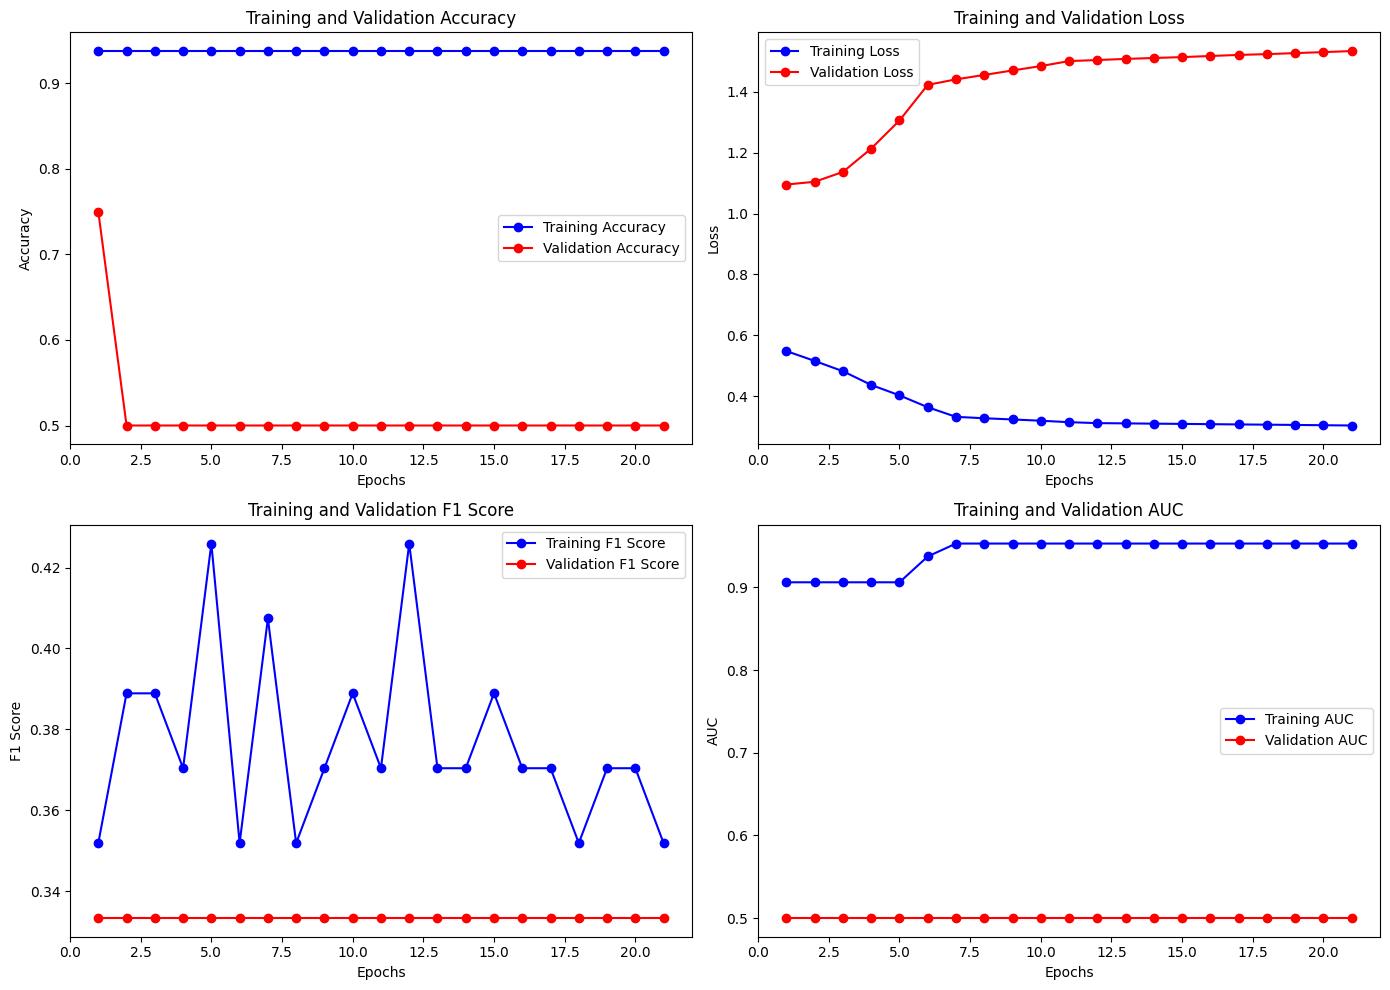

In [21]:
plot_metrics(history, "model_v1_metrics_tuner.png")